<span style="font-size: 14pt">MIPT, Applied ML, Autumn 2018</span>

<span style="font-size: 16pt"> NN for ts forecasting

<span style="color:blue; font-size: 12pt">by Radoslav Neychev </span>,

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# with open('https://raw.githubusercontent.com/ml-mipt/ml-mipt-part2/master/2017/seminars/1_ts_esm/data/TimeSeries_Data10.csv', 'r') as iofile:
#     my_ts = pd.read_csv(iofile)
    
energy_ts = pd.read_csv('https://raw.githubusercontent.com/ml-mipt/ml-mipt-part2/master/2017/seminars/2_ts_arima/data/energy_consump.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Date')
energy_ts.index.names=['Timestamp']
energy_ts.head()

,Hub,ZSP,EnergyConsump,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,Saturday,Sunday,Temp1_South_Less,Temp2_South_Less,Temp3_South_Less,Temp4_South_Less,Temp1_South_Gr,Temp2_South_Gr,Temp3_South_Gr,Temp4_South_Gr
Timestamp,,,,,,,,,,,,,,,,,,,,
2010-01-01,Center,FZSZOE27,147487.171,-17.8,-16.9,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,Center,FZSZOE27,155433.800,-17.8,-20.3,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,Center,FZSZOE27,164140.232,-16.4,-24.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,Center,FZSZOE27,171382.848,-10.2,-15.7,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,Center,FZSZOE27,170188.290,-7.2,-8.8,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
myts2 = energy_ts[['EnergyConsump', 'Temp1', 'Temp2']].dropna()

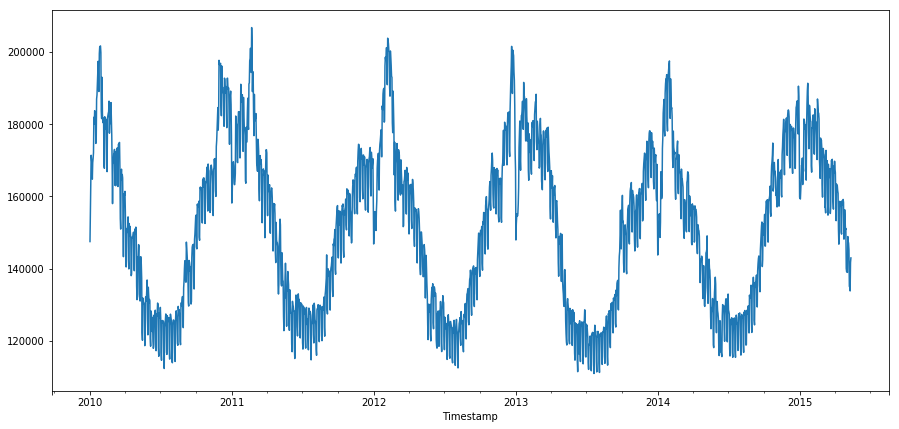

In [9]:
 myts2['EnergyConsump'].plot(figsize=(15,7))

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
myts2.values

array([[ 1.47487171e+05, -1.78000000e+01, -1.69000000e+01],
       [ 1.55433800e+05, -1.78000000e+01, -2.03000000e+01],
       [ 1.64140232e+05, -1.64000000e+01, -2.40000000e+01],
       ...,
       [ 1.33809588e+05,  9.00000000e+00,  6.50000000e+00],
       [ 1.41662124e+05,  1.40000000e+01,  1.00000000e+01],
       [ 1.42958761e+05,  0.00000000e+00,  0.00000000e+00]])

In [7]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(myts2.values)

In [8]:
scaled

array([[ 0.38140169,  0.12781955,  0.23440135],
       [ 0.46435653,  0.12781955,  0.17706577],
       [ 0.55524296,  0.15413534,  0.11467116],
       ..., 
       [ 0.23862142,  0.63157895,  0.62900506],
       [ 0.32059403,  0.72556391,  0.68802698],
       [ 0.33412962,  0.46240602,  0.51939292]])

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [11]:
reframed = series_to_supervised(scaled, n_in=7, n_out=1)
reframed.drop(reframed.columns[[22, 23]], axis=1, inplace=True)

In [12]:
reframed.shape[0]/365

5.347945205479452

In [13]:
# split into train and test sets
values = reframed.values
n_train_days = 365*4
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1460, 1, 21) (1460,) (492, 1, 21) (492,)


In [14]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [15]:
# define network
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [16]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)

Train on 1460 samples, validate on 492 samples
Epoch 1/50
1460/1460 [==============================] - 2s 2ms/step - loss: 0.2494 - val_loss: 0.1303
Epoch 2/50
1460/1460 [==============================] - 0s 322us/step - loss: 0.0951 - val_loss: 0.0561
Epoch 3/50
1460/1460 [==============================] - 0s 320us/step - loss: 0.0598 - val_loss: 0.0533
Epoch 4/50
1460/1460 [==============================] - 0s 322us/step - loss: 0.0545 - val_loss: 0.0512
Epoch 5/50
1460/1460 [==============================] - 1s 348us/step - loss: 0.0527 - val_loss: 0.0499
Epoch 6/50
1460/1460 [==============================] - 0s 312us/step - loss: 0.0519 - val_loss: 0.0493
Epoch 7/50
1460/1460 [==============================] - 0s 324us/step - loss: 0.0508 - val_loss: 0.0476
Epoch 8/50
1460/1460 [==============================] - 0s 311us/step - loss: 0.0495 - val_loss: 0.0466
Epoch 9/50
1460/1460 [==============================] - 1s 344us/step - loss: 0.0489 - val_loss: 0.0454
Epoch 10/50
1460/14

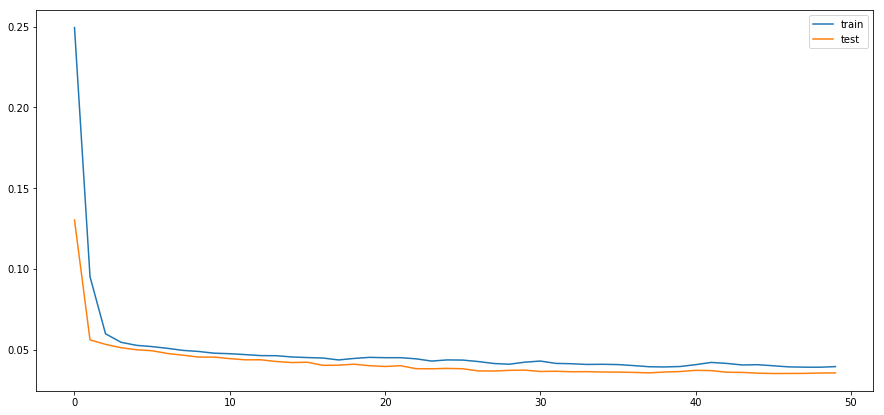

In [25]:
# plot history
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [18]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_X.squeeze(), train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
# make a prediction with NN
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, np.zeros((len(yhat), 2))), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [22]:
# make a prediction with lr
lr_yhat = lr.predict(test_X)[:, None]
# invert scaling for forecast
lr_inv_yhat = np.concatenate((lr_yhat, np.zeros((len(lr_yhat), 2))), axis=1)

lr_inv_yhat = scaler.inverse_transform(lr_inv_yhat)
lr_inv_yhat = lr_inv_yhat[:,0]

In [23]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, np.zeros((len(test_y), 2))), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [30]:
# calculate RMSE
rmse_nn = np.sqrt(mean_squared_error(inv_y, inv_yhat))
rmse_lr = np.sqrt(mean_squared_error(inv_y, lr_inv_yhat))

print('Test_RMSE_NN: %.3f,\t Test_RMSE_LR: %.3f' % (rmse_nn, rmse_lr))


Test_RMSE_NN: 4568.615,	 Test_RMSE_LR: 4327.691


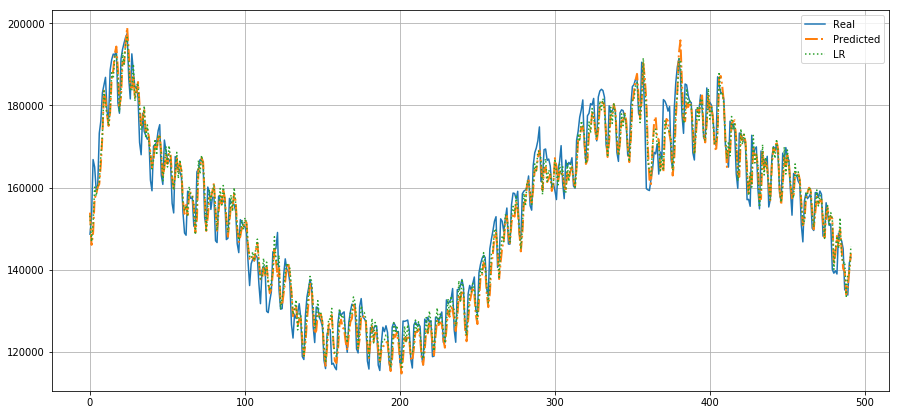

In [27]:
plt.figure(figsize=(15,7))
plt.plot(inv_y, label='Real')
plt.plot(inv_yhat, '-.', linewidth=2, label='Predicted')
plt.plot(lr_inv_yhat, ':', label='LR')
plt.grid()
plt.legend()

Conclusion: NN modification is needed